In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# configuring the json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# fetching dataset from kaggle
!kaggle datasets download -d omkargurav/face-mask-dataset

 92% 150M/163M [00:01<00:00, 179MB/s]
100% 163M/163M [00:01<00:00, 151MB/s]


In [5]:
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("extracted")

extracted


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split

In [9]:
with_mask_files = os.listdir('/content/data/with_mask')
print(with_mask_files[0:5])

['with_mask_1759.jpg', 'with_mask_2310.jpg', 'with_mask_3306.jpg', 'with_mask_3250.jpg', 'with_mask_2014.jpg']


In [10]:
without_mask_files = os.listdir('/content/data/without_mask')
print(without_mask_files[0:5])

['without_mask_3729.jpg', 'without_mask_709.jpg', 'without_mask_1483.jpg', 'without_mask_1379.jpg', 'without_mask_2526.jpg']


In [11]:
# Label encoding
with_mask_labels = [1]*3725

without_mask_labels = [0]*3828

In [12]:
print(with_mask_labels[0:5])

print(without_mask_labels[0:5])

[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


In [14]:
# saving all variables as labels
labels = with_mask_labels + without_mask_labels
print(len(labels))

7553


In [18]:
# image processing
# 1 . convert into numpy

with_mask_path = '/content/data/with_mask/'
without_mask_path = '/content/data/without_mask/'
data  = []

for img_file in with_mask_files:
  image = Image.open(with_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)

for img_file in without_mask_files:
  image = Image.open(without_mask_path + img_file)
  image = image.resize((128,128))
  image = image.convert('RGB')
  image = np.array(image)
  data.append(image)


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [19]:
type(data)

list

In [20]:
len(data)

7553

In [21]:
X = np.array(data)
Y = np.array(labels)

In [22]:
type(X)
type(Y)

numpy.ndarray

In [23]:
print(Y)

[1 1 1 ... 0 0 0]


In [24]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state=2)

In [25]:
# Scaling the data perform more better when scaled

X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [27]:
import tensorflow as tf
from tensorflow import keras

In [39]:
num_of_classes = 2

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))


model.add(keras.layers.Dense(num_of_classes, activation='sigmoid'))

In [40]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [41]:
history = model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=5)

Epoch 1/5
170/170 [==============================] - 183s 1s/step - loss: 0.5122 - acc: 0.7672 - val_loss: 0.2737 - val_acc: 0.8777
Epoch 2/5
170/170 [==============================] - 186s 1s/step - loss: 0.3013 - acc: 0.8804 - val_loss: 0.2283 - val_acc: 0.8992
Epoch 3/5
170/170 [==============================] - 171s 1s/step - loss: 0.2406 - acc: 0.9064 - val_loss: 0.2132 - val_acc: 0.9091
Epoch 4/5
170/170 [==============================] - 167s 979ms/step - loss: 0.1954 - acc: 0.9250 - val_loss: 0.2031 - val_acc: 0.9124
Epoch 5/5
170/170 [==============================] - 160s 943ms/step - loss: 0.1718 - acc: 0.9323 - val_loss: 0.2172 - val_acc: 0.9157


In [42]:
# evaluation of model

loss,accuracy = model.evaluate(X_test_scaled,Y_test)
print("Test accuracy ==>",accuracy)

48/48 [==============================] - 12s 243ms/step - loss: 0.2274 - acc: 0.9219
Test accuracy ==> 0.9219059944152832


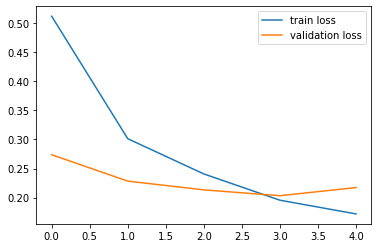

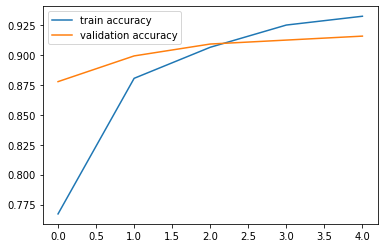

In [43]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['acc'], label='train accuracy')
plt.plot(h.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

Path of the image to be predicted: /content/data/without_mask/without_mask_1022.jpg


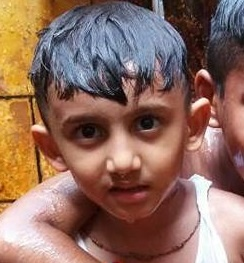

1/1 [==============================] - 0s 40ms/step
[[0.05552233 0.83235395]]
1
The person in the image is not wearing a mask


In [50]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)

input_image_resized = cv2.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)


input_pred_label = np.argmax(input_prediction)

print(input_pred_label)


if input_pred_label == 0:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')

Path of the image to be predicted: /content/data/with_mask/with_mask_1012.jpg


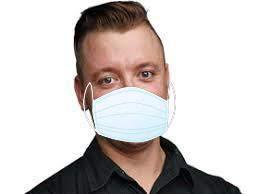

1/1 [==============================] - 0s 59ms/step
[[0.6494212  0.29627538]]
0
The person in the image is wearing a mask


In [51]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)

input_image_resized = cv2.resize(input_image, (128,128))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,128,128,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)


input_pred_label = np.argmax(input_prediction)

print(input_pred_label)


if input_pred_label == 0:

  print('The person in the image is wearing a mask')

else:

  print('The person in the image is not wearing a mask')